In [144]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import datetime as dt
import numpy.random as rd
import matplotlib.pyplot as plt
import os
import scipy.stats as si
import statsmodels.api as sm

In [39]:
#unclear if necessary to use in jupyter
# os.chdir(os.path.dirname(__file__))
# print(os.getcwd())

In [40]:
def load_financial_data(name, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading',name,'data')
    except FileNotFoundError:
        print('File not found...downloading', name, 'data')
        df = data.DataReader(name, 'yahoo', '2001-01-01', '2019-11-24')
        df.to_pickle(output_file)
    return df

def euro_vanilla_call(S, K, T, r, d, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity/
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - d - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-(r-d) * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [41]:
def get_logreturn(yahoo_dataframe):
    out = pd.DataFrame(index = yahoo_dataframe.index)
    prices = yahoo_dataframe.Close
    days = pd.Series(yahoo_dataframe.index).dt.day
    daydelta = days.iloc[1:].values - days.iloc[:-1].values
    out['LogReturn'] = np.log(prices.shift(-1)/prices).dropna()/np.sqrt(daydelta)
    return out

def get_sigma():
    daybasis = 252
    SP500 = load_financial_data('^GSPC', '^GSPC_data.pkl')
    lreturns = get_logreturn(SP500)
    pastyears = lreturns.iloc[-n_years*daybasis:]
    dailyvol = pastyears.std()[0]
    yearlyvol = dailyvol*np.sqrt(daybasis)
    return yearlyvol

def get_latest_price():
    return load_financial_data('^GSPC', '^GSPC_data.pkl').iloc[-1].Close

In [42]:
SP500 = load_financial_data('^GSPC', '^GSPC_data.pkl')
lreturns = get_logreturn(SP500)

File data found...reading ^GSPC data


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


# 1. Extracting Historical Parameters

In [43]:
daybasis = 252
n_years = 3
pastyears = lreturns.iloc[-n_years*daybasis:]
dailyvol = pastyears.std()[0]

yearlyvol = dailyvol*np.sqrt(daybasis)
dailyalpha = pastyears.mean() + dailyvol**2/2
yearlyalpha = dailyalpha*daybasis

In [280]:
num_random = 250
def RegenerateRandomNumbers():
    """ 
    Generate 2 sets of random numbers of num random size.
    Then, uses antithetic variates and the normal distribution as a control variate
    """
    global Z1, Z2
    Z1 = rd.randn(num_random,1)
    Z2 = rd.randn(num_random,1)
    Z1 = np.vstack((Z1, -Z1))
    Z2 = np.vstack((Z2,-Z2))
    
    
    #control variate method, denorming Z1 and Z2
    Z1 = (Z1-Z1.mean())/Z1.std()
    Z2 = (Z2-Z2.mean())/Z2.std()

RegenerateRandomNumbers();
    
def SimulateStock(S0,t, sigma, Z):
    Sn = S0*np.exp(( r - d - sigma**2/2)*t + sigma*Z * np.sqrt(t))
    return Sn

def SimulateAllRelevantStocks(S0, t, T, sigma, Z1, Z2):
    Shalf = S0*np.exp(( r - d - sigma**2/2)*t + sigma*Z1* np.sqrt(t))
    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-t) + sigma*Z2 * np.sqrt(T-t)) 
    return Shalf, S1
    
def MatrixTriggerPayoff(Qs, F, Shalf, S1):
    """
    This function takes an entire vector of possible shout levels and possible stock paths,
    and returns the payoff for each stock path at each shout level individually.
    DO NOT TRY THIS AT HOME UNLESS YOU KNOW WHAT YOU'RE DOING WITH NUMPY'S ARRAY FUNCTIONALITY.
    vectorized form of TriggerPayoff.
    Hypothetically, faster.
    """
    Shalfs = np.repeat(Shalf, len(Qs), axis = 1)
    S1s = np.repeat(S1, len(Qs), axis = 1)    
    Payoff = np.maximum(S1s-K, 0)
    Payoff[Shalfs < Qs] = F
    return Payoff
    
def TriggerPayoff(Q, F, Shalf, S1):
#def TriggerPayoff(Q, F):
    """ calculates trigger payoff for a given exercise level Q via Monte Carlo simulation"""
    
#    Shalf = SimulateStock(S,trig, Z1)
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
    
#    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-trig) + sigma*Z2 * np.sqrt(T-trig)) 
#    S1 = SimulateStock(Shalf, T-trig, Z2)
    
    Payoff = np.maximum(S1-K, 0)
    Payoff[Shalf < Q] = F
#    meanPayoff = np.smean(Payoff)
#    return np.hstack((Shalf, Payoff))
#    return meanPayoff*np.exp(-r*T)
    return Payoff

def TriggerMeanPayoff(Q,F, Shalf, S1):
#     return np.mean(TriggerPayoff(Q,F, Shalf, S1))*np.exp(-r*T)
    
    #vectorized form:
    return np.mean(TriggerPayoff(Q, F, Shalf, S1), axis = 0)*np.exp(-r*T)

def HalfYearCall(Shalf):
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
    Payoff = np.maximum(Shalf-K,0)
#    return np.mean(Payoff)*np.exp(-r*T)
    return Payoff

def HalfYearPayoff(Shalf):
    return np.mean(HalfYearCall(Shalf))*np.exp(-r*T)
     
#theoretically, at T=.5, the option is either an option to get a fixed payment or a call.
def TwoPeriodEuroCall(S1):
    """calculates the value of a vanilla european call using common random numbers of the shout option
    honeslty at this point just pretend this isn't a thing
    """
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
#    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-trig) + sigma*Z2 * np.sqrt(T-trig))
    Payoff = np.maximum(S1-K,0)
#    return np.mean(Payoff)*np.exp(-r*T)
    return Payoff

def TwoPeriodEuroPayoff(S1):
    return np.mean(TwoPeriodEuroCall(S1))*np.exp(-r*T)

#%% sets parameters
sigma = yearlyvol
T = 1
trig = .5
r = .0158
d = .0185
S = SP500.iloc[-1].Close
F = 10
#K = 3150

In [45]:
# reads option data
options = pd.read_excel("options.xlsx")
#options = pd.read_csv("options.csv")
c1yr = options.loc[:, 'Dec 2020 call'].values # traded call options price
chalfyr = options.loc[:, 'Jun 2020 call'].values
Ks = options.loc[:, 'strike'].values/100 # strike price
# suppose maturity = 1 
bs_c = []

for i in Ks:
    bs_c.append(euro_vanilla_call(S, i, T, r, d,sigma))
    
bs_c = np.asarray(bs_c, dtype=np.float64).reshape(-1,1)
#Xs is a matrix of theoretical black scholes price and strike. 
Xs = np.hstack((bs_c, Ks.reshape(-1,1)))

# 2. Benchmarking traded options to theoretical Black Scholes Options

slope:  1.2590542854175693
intercept:  -11.739911398243322
r2 score:  0.9999899259644417


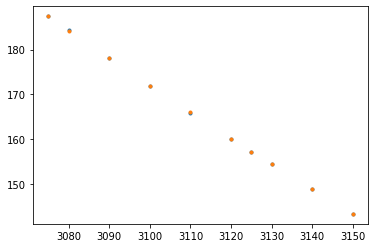

In [46]:
#linear regression to connect the black scholes call price to the 1 year call price
# establishes a link between the theoretical black scholes and market observed prices
# so, using a given result from the black scholes formula, we can fill in the blanks for what the market would say
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
regressor = LinearRegression()
#regressorb = LinearRegression()
model_1 = regressor.fit(bs_c, c1yr)

b_year, a_year = model_1.coef_[0], model_1.intercept_

print('slope: ',b_year)
print('intercept: ',a_year)
print('r2 score: ',r2_score(model_1.coef_*bs_c+model_1.intercept_, c1yr))

#multlin_1 = regressorb.fit(Xs,c1yr)
#print(multlin_1.coef_)
#print(multlin_1.intercept_)
#print(r2_score( np.sum(multlin_1.coef_*Xs, axis = 1)+multlin_1.intercept_, c1yr))

plt.plot(Ks, model_1.coef_*bs_c+model_1.intercept_, '.')
#plt.plot(Ks, np.sum(multlin_1.coef_*Xs, axis = 1)+multlin_1.intercept_, '.')
plt.plot(Ks,c1yr, '.')

slope:  1.35193212997858
intercept:  5.464200693491563
r2 score:  0.999769619955707


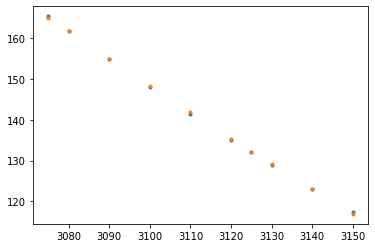

In [47]:
# suppose maturity = 0.5 
# regresses half year black scholes theoretical call price to real call price
bs_c2 = []
for i in Ks:
    bs_c2.append(euro_vanilla_call(S, i, trig, r, d,sigma))
    
bs_c2 = np.asarray(bs_c2, dtype=np.float64).reshape(-1,1)

regressor2 = LinearRegression()
model_2 = regressor2.fit(bs_c2, chalfyr)

b_half, a_half = model_2.coef_[0], model_2.intercept_
print('slope: ', b_half)
print('intercept: ', a_half)
print('r2 score: ',r2_score(model_2.coef_*bs_c2+model_2.intercept_, chalfyr))

plt.plot(Ks, model_2.coef_*bs_c2+model_2.intercept_, '.')
plt.plot(Ks, chalfyr, '.')

In [48]:
# for strikes between  3075 and 3150, for options of 1 year and half a year
# of course, this might not be necessary -- it might be simpler to get straight to the point
# which means regress directly: (what to what?)
# simulate shout values, let those be Y
# xs are then... 
# I guess it could be with different strike prices to empirically determine a payoff function for a shout
# theoretically with a shout F of 0, the damn thing should converge to a european call
# anyways, what we want is an equation of form a + b1 O1 + b2 O2,
# where a is a fixed cost, b1 is the relation to the half year option, and b2 is the relation to the year option
# how do we benchmark this? mentally I'm stuck
# information we have: simulated half year stock prices, full year stock prices
# market data: half year option, full year option
# option one: multilinear regression, monte carlo half year to known option price, full year to known option

# wait: what's the x data and y? the y is the simulated shout option price.
# the xs are therefore some combination of the simulated stock prices and the known real option prices
# so for each loop: simulate a shout price, as well as the two stock prices at each time
# then do the regression on the value of the OPTION at time .5 and time 1
# shout = a + b1 * option.5 + b2*option1
# then, we use the actual values of the options at .5 and 1 to get the 'actual value' of the shout??
print(a_year, b_year, a_half, b_half)

def scaled_eurocall(bsprice, alpha, beta):
    return bsprice*beta + alpha

-11.739911398243322 1.2590542854175693 5.464200693491563 1.35193212997858


# 3. Wrapper Function for Simulating and Regression on a Shout Option

In [281]:
placekey = 5
k = Ks[placekey]
K = k
minrange = round((S+K)/2 -750)
maxrange = round((S+K)/2 +750)
step = .1
steprange = np.arange(minrange, maxrange, step)

def estimate_prices(k, sigma_):

    T = 1
    trig = .5
    r = .0158
    d = .0185
    S = SP500.iloc[-1].Close
    F = 100 #we want some F that makes the shout more valuable than the vanilla
#    F = 0 #dummy to check convergence to vanilla
    # when this F=0 condition is true, we would expect the value to be identical to vanilla.
    
    K = k

    payoffs = []
    basepays = []
    eurocall = []
    trueeurocall = []
    strikes = []
    
    Shalf, S1 = SimulateAllRelevantStocks(S, trig, T, sigma_, Z1, Z2)
    
    simeurcall = TwoPeriodEuroPayoff(S1) #common random number eurocall
    
    
    bseurcall = scaled_eurocall(euro_vanilla_call(S,K,T,r,d,sigma_), a_year, b_year )
    #analytical eurocall, scaled to market data
    
#     for i in steprange:
#         # this payoff takes the control variate technique and applies it to the trigger payoff
#         # we know what the analytical european call price should be
#         # we can simulate the european call price using the same common random numbers as the trigger
#         # thus, we can correct the effect of the randomnuess on the trigger payoff via:
#         # simulated_trigger - simulated_european + analytical_european
#         basepay = TriggerMeanPayoff(i,F, Shalf, S1)

#         j = basepay - simeurcall + bseurcall
#         # I have no idea of this use of control variate is compatible with benchmarking
#         # but strictly speaking this is perfectly valid
#         #alright, this is valid in the formulation that returns average payoffs
        
#         payoffs.append(j)
#         basepays.append(basepay)
        
#         # these are done to display a straight line of call price. 
# #        eurocall.append(simeurcall)
# #        trueeurocall.append(bseurcall)
        
#         #this is necessary for best q level
#         strikes.append(i)
    
    basepay = np.mean(MatrixTriggerPayoff(steprange, F, Shalf, S1), axis = 0)*np.exp(-r*T)
#     payoffs = basepay - simeurcall + bseurcall #     attempted control variate implementation 
    payoffs = basepay
    
#    plt.plot(steprange, payoffs)
#    plt.plot(steprange, trueeurocall)
    
    
    #    plt.plot(steprange, eurocall)
    
#     bestq = strikes[payoffs.index(max(payoffs))]
    bestq = steprange[np.argmax(payoffs)]
    
    trigger = TriggerPayoff(bestq,F, Shalf, S1)
    
    Xs = np.hstack((HalfYearCall(Shalf), TwoPeriodEuroCall(S1)))
    STDs = Xs.var(axis = 0)
    
    regressor = sm.GLS(trigger, add_constant(Xs))
    model = regressor.fit()
    
#     regressor = LinearRegression()
#     model = regressor.fit(Xs, trigger)
    
    value = max(payoffs)
#    print('value: ',value, 
##          'true-vanilla: ', trueeurocall[0],    
#          '\n',
#          'unadj value', max(basepays),
##          'sim-vanilla: ', max(eurocall), 
#          '\n',
#          'best Q level: ', bestq)
    return value, bestq, model, payoffs


# Function to benchmark Shout Option Price from Regression Results

In [244]:
def benchmark_prices(reg_results):
    c1 = c1yr[placekey]
    ch = chalfyr[placekey]
    benchmarkcalls = np.array((ch, c1))
    benchmarkedprices = []
    for reg in reg_results:
    #    price = reg.coef_[0]*ch + reg.coef_[1]*c1 + reg.intercept_
#         price = (np.dot(reg.coef_,benchmarkcalls) + reg.intercept_)[0]
        price = np.dot(reg.params, np.hstack((np.ones(1),benchmarkcalls)))
        # can also use reg.predict()
#        print(reg.coef_, reg.intercept_)
        benchmarkedprices.append(price)
    return benchmarkedprices

# Simulation of Shout Option at $\sigma$ and $\sigma + 3\%$

In [282]:
#k = 3120
# referential equivalent for k = 3120:
#placekey = 4
#k = Ks[placekey]
#
#minrange = round((S+K)/2 -750)
#maxrange = round((S+K)/2 +750)
#step = .2
#steprange = np.arange(minrange, maxrange, step)

values_base = []
optimalqs_base = []
regression_results_base = []
payofflist_base = []

values_spread = []
optimalqs_spread = []
regression_results_spread = []
payofflist_spread = []

for j in range(100):        
    # if, at time of submission, the range is 1, that's because I was in the process of reworking this to not be a for loop averaging over several monte carlo simulations
    # that's 1.slow 2.of dubious rigor.
    # therefore, looking for a way of handling error propagation down a monte carlo simulation via regression
    
    #well, monte carlo of monte carlo. Logic suggests large number of repeats of secondary monte carlo but small of primary
    # could probably vectorize actually
    
    # common random numbers approach
    RegenerateRandomNumbers()
    
    v, q, rr, ps = estimate_prices(k, yearlyvol)
    values_base.append(v)
    optimalqs_base.append(q)
    regression_results_base.append(rr)
    payofflist_base.append(ps)
    
    v, q, rr, ps = estimate_prices(k, yearlyvol + .03)
    values_spread.append(v)
    optimalqs_spread.append(q)
    regression_results_spread.append(rr)
    payofflist_spread.append(ps)

# Results and Output

Shout price:  191.48561378164123
Shout MLE:  0.44981297379465196

Shout price with spread:  192.54252159955715
Shout spread MLE:  0.49699635769837486

Difference in price with spread:  1.0569078179159135
sum of risks:  0.9468093314930268

worse case scenario:
"vanilla" shout + MLE:  191.93542675543588
"spread" shout - MLE:  192.04552524185877
difference between two:  0.11009848642288489


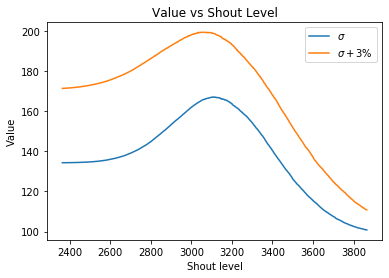

In [290]:
payofflist_base = np.array(payofflist_base)
payofflist_spread = np.array(payofflist_spread)
# for payoffs in payofflist_base:
#     plt.plot(steprange, payoffs)
basemean = payofflist_base.mean(axis = 0)

plt.plot(steprange, payofflist_base.mean(axis = 0))
plt.plot(steprange, payofflist_spread.mean(axis = 0))
plt.title('Value vs Shout Level')
plt.xlabel('Shout level')
plt.ylabel('Value')
plt.legend([r'$\sigma$', r'$\sigma + 3\%$'])

#initial attempt at adding confidence bounds; unnecessary.
# plt.fill_between(steprange, basemean-5*basemle, basemean+5*basemle, color='b', alpha=.1)
# for payoffs in payofflist_spread:
#     plt.plot(steprange, payoffs)
    
values_base = np.array(values_base)
optimalqs_base = np.array(optimalqs_base)
prices = np.array(benchmark_prices(regression_results_base))
#values.mean(), values.std(), prices.mean(), prices.std(), optimalqs.mean(), optimalqs.std()

stats_bm = (prices.mean(), prices.std())
# stats_bm = (prices[0],regression_results_base[0])
print('Shout price: ',stats_bm[0])
print('Shout MLE: ', 2*stats_bm[1]/np.sqrt(len(payofflist_base)))
   
spread_prices = np.array(benchmark_prices(regression_results_spread))
stats_spread = (spread_prices.mean(), spread_prices.std())
# stats_spread = (spread_prices[0],0)

basemle = 2*stats_bm[1]/np.sqrt(len(payofflist_base))
spreadmle = 2*stats_spread[1]/np.sqrt(len(payofflist_base))

print('')
print('Shout price with spread: ',stats_spread[0])
print('Shout spread MLE: ', 2*stats_spread[1]/np.sqrt(len(payofflist_spread)))
print('')

print('Difference in price with spread: ',stats_spread[0]-stats_bm[0])
print('sum of risks: ', 2*stats_spread[1]/np.sqrt(len(payofflist_spread)) + 2*stats_bm[1]/np.sqrt(len(payofflist_base)))
print('')
print('worse case scenario:')
print('"vanilla" shout + MLE: ', stats_bm[0] + basemle)
print('"spread" shout - MLE: ', stats_spread[0] - spreadmle)
print('difference between two: ', stats_spread[0] - spreadmle - (stats_bm[0] + basemle))

In [118]:
print('Optimal Exercise Boundary: ',optimalqs_base.mean())
    
print('Optimal Exercise Boundary with spread: ',np.mean(optimalqs_spread))
# indicates that as vol rises optimal exercise boundary falls
# print(np.std(optimalqs_base), np.std(optimalqs_spread))

Optimal Exercise Boundary:  3122.604999999311
Optimal Exercise Boundary with spread:  3072.8149999993566


Hedging is done in attached pdf.

## Test Code and other Errata

In [119]:
# payofflist_base.mean(axis = 0)
Z1.shape

(10000, 1)

In [120]:
np.vstack((Z1, -Z1)).std()

0.9999999999999999

In [122]:
steprange.shape

(15000,)

In [86]:
Shalf, S1 = SimulateAllRelevantStocks(S, trig, T, sigma, Z1, Z2)


In [165]:
for reg in regression_results_base:
    print(reg.params)

[5.5817860e+01 4.5970908e-02 8.0186819e-01]


In [203]:
regression_results_base[0].params

array([5.5817860e+01, 4.5970908e-02, 8.0186819e-01])

In [188]:
Xs = np.hstack((HalfYearCall(Shalf), TwoPeriodEuroCall(S1)))

In [204]:
Xs.var(axis = 0)

array([23405.33742625, 47542.07663559])

30618.66627628618

In [232]:
covs = regression_results_base[0].cov_params()[1:,1:]
covs

array([[ 3.41728908e-05, -1.50742339e-05],
       [-1.50742339e-05,  1.64616384e-05]])

In [236]:
betas = regression_results_base[0].params[1:].reshape(-1,1)
betas

array([[0.04597091],
       [0.80186819]])

In [239]:
np.dot(covs, betas**2).sum()

9.324524375191534e-07

In [241]:
np.sqrt(np.dot(Xs.var(axis = 0), betas**2))

array([174.98190271])

In [260]:
payofflist_spread

array([[195.31658005, 195.31658005, 195.31658005, ..., 127.90466768,
        127.90466768, 127.90466768],
       [173.82180964, 173.82180964, 173.82180964, ..., 122.24314162,
        122.24314162, 122.24314162],
       [156.65811834, 156.65811834, 156.65811834, ..., 105.64213878,
        105.64213878, 105.64213878],
       ...,
       [196.23238512, 196.23238512, 196.23238512, ..., 119.68482586,
        119.68482586, 119.68482586],
       [166.48044125, 166.48044125, 166.48044125, ..., 116.1324434 ,
        116.1324434 , 116.1324434 ],
       [180.73217141, 180.73217141, 180.73217141, ...,  98.43241652,
         98.43241652,  98.43241652]])